This file is to test my model on the TUH-EEG-seizure data

Not DMD


In [1]:
RUN_PYTHON_SCRIPT = False
MODEL_NAME_LIST = [
    "Lay2_dis_1step_epoch1", 
    "Lay2_dis_1step_epoch2", 
    "Lay2_dis_1step_epoch3",
    "Lay2_dis_1step_correct_epoch1", 
    "Lay2_dis_1step_correct_epoch2", 
    "Lay2_dis_1step_correct_epoch3"];

In [2]:
import sys
sys.path.append("../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from easydict import EasyDict as edict
import time

if not RUN_PYTHON_SCRIPT:
    plt.style.use(FIG_ROOT/"base.mplstyle")

In [4]:
import importlib
import data_utils.eeg_load
importlib.reload(data_utils.eeg_load)

<module 'data_utils.eeg_load' from '/data/rajlab1/user_data/jin/MyResearch/gTVDN-NN/notebooks/../mypkg/data_utils/eeg_load.py'>

In [5]:
#from models.main_model import myNet
from models.model_utils import generate_position_encode
from data_utils.eeg_load import EEG_data, MyDataLoader, digitize_data, rec_data
from utils.misc import delta_time, load_pkl_folder2dict, save_pkl_dict2folder, truncated_mean_upper

In [6]:
# pkgs for pytorch (on Apr 3, 2023)
import torch
import torch.nn as nn
from torch.functional import F
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm import trange, tqdm

torch.set_default_dtype(torch.float64)
if torch.cuda.is_available():
    #torch.cuda.set_device(3)
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda")
else:
    torch.set_default_tensor_type(torch.DoubleTensor)
    device = torch.device("cpu")

In [7]:
from sklearn.metrics import confusion_matrix
from collections import defaultdict as ddict

In [9]:
def raw2input(X, pos_enc):
    X_input = X + pos_enc
    X_raw = X
    return X_input, X_raw

def _raw_pred_dis(X):
    X_inp, X_raw = raw2input(X, pos_enc)
    trained_model.eval()
    with torch.no_grad():
        Y_pred_prbs = trained_model(X_inp, X_raw)
    Y_pred_dis = Y_pred_prbs.argmax(axis=-1)
    Y_pred = rec_data(Y_pred_dis.cpu().numpy(), config.k)
    Y_pred = torch.tensor(Y_pred)
    return Y_pred

def pred_steps(X_init, raw_pred, num_step):
    """To make num_step prediction based on X_init 
        args:
            X_init: batchsize x blocksize x numseq, tensor
            raw_pred: A fn to make prediction for 1 step
            num_step: num of steps
    """
    X_ext = X = X_init 
    for k in range(num_step):
        Y_pred = raw_pred(X);
        X_ext = torch.cat([X_ext, Y_pred[:, -1:, :]], axis=1)
        X = X_ext[:, -config.block_size:]
    Y_pred_mul = X_ext[:, -num_step:];
    return Y_pred_mul

In [9]:
num_step_uplimit = 512
num_seq_total = 256

for MODEL_NAME in MODEL_NAME_LIST:
    model_res = load_pkl_folder2dict(RES_ROOT/f"{MODEL_NAME}", including=["model", "config"], verbose=False);
    config = model_res.config
    trained_model = model_res.model;
    pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0);
    
    train_data = EEG_data("train_train", "AR", 
                          move_dict=dict(winsize=config.block_size+num_step_uplimit,
                                         stepsize=config.block_size+num_step_uplimit,
                                         marginsize=None),
                          preprocess_dict=dict(is_detrend=True, 
                                          is_drop=True,
                                          target_fs=90, 
                                          filter_limit=[1, 45], 
                                          is_diff=False)
                         )
    test_data = EEG_data("train_test", "AR", 
                          move_dict=dict(winsize=config.block_size+num_step_uplimit, 
                                         stepsize=config.block_size+num_step_uplimit, 
                                         marginsize=None),
                          preprocess_dict=dict(is_detrend=True, 
                                          is_drop=True,
                                          target_fs=90, 
                                          filter_limit=[1, 45], 
                                          is_diff=False)
                        )
    
    train_data_loader = MyDataLoader(train_data, batch_size=4, shuffle=False)
    test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
    
    for num_step in [1, 2, 4, 8, 16, 32, 64, 128]:
        save_path = MIDRES_ROOT/f"{MODEL_NAME}_{num_step}step_pred_labs"
        if save_path.exists():
            save_res = load_pkl_folder2dict(save_path)
        else:
            save_res = ddict(list)
        
        all_true_dis = []
        all_pred_dis = []
        #sel_idxs = np.random.choice(len(test_data_loader), size=int(num_seq_total/num_step), replace=False)
        sel_idxs = np.arange(int(num_seq_total/num_step))
        for ix in tqdm(sel_idxs, desc=f"{MODEL_NAME} {num_step} step"):
        
            batch = test_data_loader(ix) * 1e6;
            X_init = batch[:, :config.block_size];
            Y_true_mul = batch[:, config.block_size:(config.block_size+num_step)]
            Y_pred_mul = pred_steps(X_init, _raw_pred_dis, num_step)
            
            Y_true_mul_dis = digitize_data(Y_true_mul.cpu().numpy(), config.k);
            Y_pred_mul_dis = digitize_data(Y_pred_mul.cpu().numpy(), config.k);
            all_true_dis.append(Y_true_mul_dis.flatten())
            all_pred_dis.append(Y_pred_mul_dis.flatten());
            
        all_true_dis = np.concatenate(all_true_dis)
        all_pred_dis = np.concatenate(all_pred_dis);
        
        save_res["all_trues_dis"].append(all_true_dis)
        save_res["all_preds_dis"].append(all_pred_dis)
        save_pkl_dict2folder(save_path, save_res, is_force=True, verbose=False)

Lay2_dis_1step_epoch3 128 step: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.59s/it]


In [10]:
# baseline, moveforward
config = model_res.config
    
train_data = EEG_data("train_train", "AR", 
                          move_dict=dict(winsize=config.block_size+num_step_uplimit,
                                         stepsize=config.block_size+num_step_uplimit,
                                         marginsize=None),
                          preprocess_dict=dict(is_detrend=True, 
                                          is_drop=True,
                                          target_fs=90, 
                                          filter_limit=[1, 45], 
                                          is_diff=False)
                         )
test_data = EEG_data("train_test", "AR", 
                          move_dict=dict(winsize=config.block_size+num_step_uplimit, 
                                         stepsize=config.block_size+num_step_uplimit, 
                                         marginsize=None),
                          preprocess_dict=dict(is_detrend=True, 
                                          is_drop=True,
                                          target_fs=90, 
                                          filter_limit=[1, 45], 
                                          is_diff=False)
                        )
    
train_data_loader = MyDataLoader(train_data, batch_size=4, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)
    
for num_step in [1, 2, 4, 8, 16, 32, 64, 128]:
        save_path = MIDRES_ROOT/f"baseline_{num_step}step_pred_labs"
        if save_path.exists():
            save_res = load_pkl_folder2dict(save_path, verbose=False)
        else:
            save_res = ddict(list)
        
        all_true_dis = []
        all_pred_dis = []
        sel_idxs = np.random.choice(len(test_data_loader), size=int(num_seq_total/num_step), replace=False)
        #sel_idxs = np.arange(int(num_seq_total/num_step))
        for ix in tqdm(sel_idxs, desc=f"baseline {num_step} step"):
        
            batch = test_data_loader(ix) * 1e6;
            X_init = batch[:, :config.block_size];
            Y_true_mul = batch[:, config.block_size:(config.block_size+num_step)]
            Y_pred_mul = X_init[:, -1:, :].repeat(1, num_step, 1)
            
            Y_true_mul_dis = digitize_data(Y_true_mul.cpu().numpy(), config.k);
            Y_pred_mul_dis = digitize_data(Y_pred_mul.cpu().numpy(), config.k);
            all_true_dis.append(Y_true_mul_dis.flatten())
            all_pred_dis.append(Y_pred_mul_dis.flatten());
            
        all_true_dis = np.concatenate(all_true_dis)
        all_pred_dis = np.concatenate(all_pred_dis);
        
        save_res["all_trues_dis"].append(all_true_dis)
        save_res["all_preds_dis"].append(all_pred_dis)
        save_pkl_dict2folder(save_path, save_res, is_force=True, verbose=False)

baseline 128 step: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.22it/s]


In [10]:
_key_fn = lambda f: int(f.stem.split("step")[-2].split("_")[-1])
def _measure_fn(a, b):
    return np.mean(np.abs(a-b))

all_plot_res = edict()
for MODEL_NAME in MODEL_NAME_LIST + ["baseline"]:
    fils = list(MIDRES_ROOT.glob(f"{MODEL_NAME}_*"));
    steps = np.array([_key_fn(f) for f in fils]);
    fils = sorted(fils, key=_key_fn);
    
    measures = []
    for fil in fils:
        cur_res = load_pkl_folder2dict(fil, verbose=False)
        measures.append(np.mean([_measure_fn(a, b) for a, b in zip(cur_res.all_preds_dis, cur_res.all_trues_dis)]))
    all_plot_res[MODEL_NAME] = (steps, measures)
    
#plt.plot(steps, measures, "-o")
#plt.xscale("log")

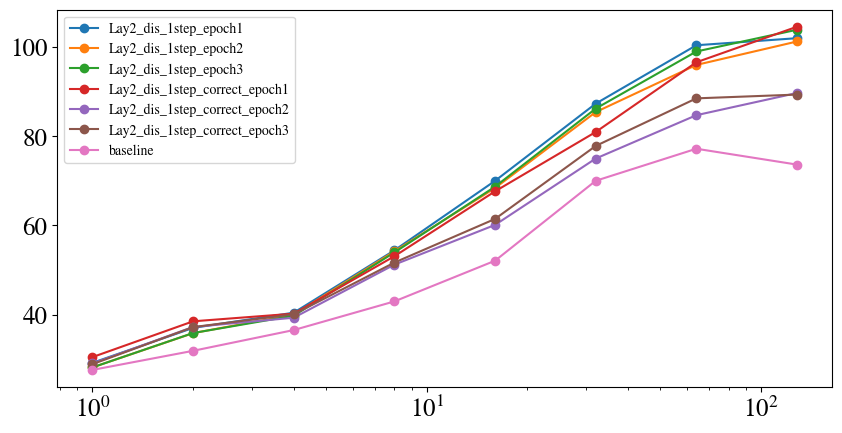

In [11]:
for key, v in all_plot_res.items():
    plt.plot(v[0], v[1], label=key, marker="o")
plt.xscale("log")
plt.legend(fontsize=10)

In [13]:
all_plot_res

{'Lay2_dis_1step_epoch1': [array([  1,   2,   4,   8,  16,  32,  64, 128]),
  [29.19104646381579,
   37.02225534539474,
   40.43025287828947,
   54.41169819078947,
   69.99434621710526,
   87.30263157894737,
   100.39535361842105,
   101.98046875]],
 'Lay2_dis_1step_epoch2': [array([  1,   2,   4,   8,  16,  32,  64, 128]),
  [28.158871299342106,
   35.85202508223684,
   39.996145148026315,
   54.192537006578945,
   68.38656455592105,
   85.40650699013158,
   95.98216488486842,
   101.23709909539474]],
 'Lay2_dis_1step_epoch3': [array([  1,   2,   4,   8,  16,  32,  64, 128]),
  [28.16200657894737,
   35.86950041118421,
   39.75673314144737,
   53.94212582236842,
   68.68765419407895,
   86.19017269736842,
   98.99542557565789,
   103.87669613486842]],
 'baseline': [array([  1,   2,   4,   8,  16,  32,  64, 128]),
  [27.598761307565788,
   31.881681743421055,
   36.536865234375,
   42.96280067845395,
   52.082442434210535,
   70.0048828125,
   77.19154759457237,
   73.6337890625]]}

<AxesSubplot:>

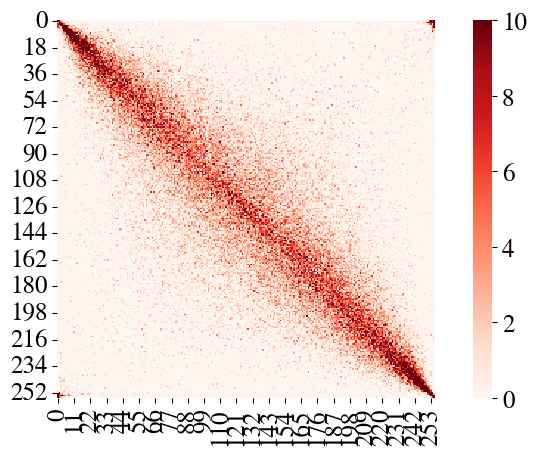

In [14]:
MODEL_NAME = "baseline"
#MODEL_NAME = MODEL_NAME_LIST[-1]
fils = list(MIDRES_ROOT.glob(f"{MODEL_NAME}_*"));
cur_res = load_pkl_folder2dict(fils[0], verbose=False)

conf_mat = confusion_matrix(np.concatenate(cur_res.all_trues_dis), 
                            np.concatenate(cur_res.all_preds_dis));
sns.heatmap(conf_mat, square=True, cmap="Reds", vmax=10)

In [15]:
from models.losses import ordinal_mse_loss

In [16]:
num_step_uplimit = 512
num_seq_total = 256
MODEL_NAME = MODEL_NAME_LIST[0]
model_res = load_pkl_folder2dict(RES_ROOT/f"{MODEL_NAME}", including=["model", "config"], verbose=False);
config = model_res.config
trained_model = model_res.model;
pos_enc = generate_position_encode(config.block_size, config.nfeature).unsqueeze(0);
train_data = EEG_data("train_train", "AR", 
                          move_dict=dict(winsize=config.block_size+num_step_uplimit,
                                         stepsize=config.block_size+num_step_uplimit,
                                         marginsize=None),
                          preprocess_dict=dict(is_detrend=True, 
                                          is_drop=True,
                                          target_fs=90, 
                                          filter_limit=[1, 45], 
                                          is_diff=False)
                         )
test_data = EEG_data("train_test", "AR", 
                          move_dict=dict(winsize=config.block_size+num_step_uplimit, 
                                         stepsize=config.block_size+num_step_uplimit, 
                                         marginsize=None),
                          preprocess_dict=dict(is_detrend=True, 
                                          is_drop=True,
                                          target_fs=90, 
                                          filter_limit=[1, 45], 
                                          is_diff=False)
                        )
train_data_loader = MyDataLoader(train_data, batch_size=4, shuffle=False)
test_data_loader = MyDataLoader(test_data, batch_size=4, shuffle=False)

ix = 1
batch = test_data_loader(ix) * 1e6;
X_init = batch[:, :config.block_size];
Y_true = batch[:, 1:(config.block_size+1)]
Y_true_dis = torch.tensor(digitize_data(Y_true, config.k));

X_inp, X_raw = raw2input(X_init, pos_enc)
trained_model.eval()
with torch.no_grad():
    Y_pred_prbs = trained_model(X_inp, X_raw)
Y_pred_dis = Y_pred_prbs.argmax(axis=-1);
#Y_pred_dis = Y_pred_prbs.argsort(axis=-1)[:, :, :, -3:].median(axis=-1)[0]
Y_pred_prbs1 = nn.functional.one_hot(Y_pred_dis, num_classes=2**config.k).double();


In [17]:
ordinal_mse_loss(Y_pred_prbs, Y_true_dis, num_cls=2**config.k)

tensor(0.0711)

In [18]:
ordinal_mse_loss(Y_pred_prbs1, Y_true_dis, num_cls=2**config.k)

tensor(0.1080)

<AxesSubplot:>

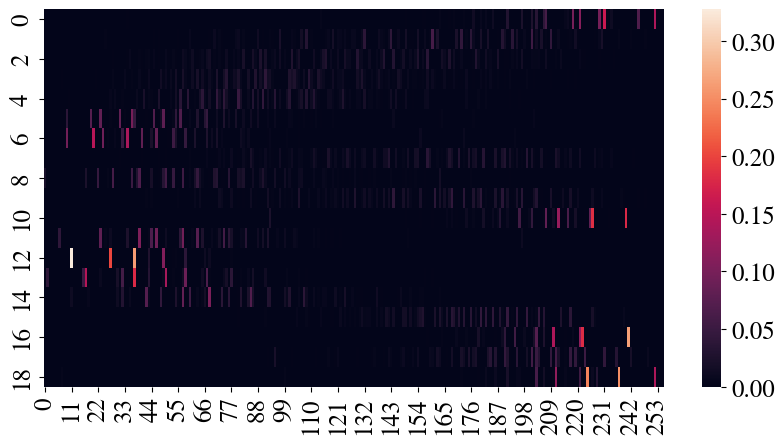

In [20]:
sns.heatmap(Y_pred_prbs[1, 2, :])